In [2]:
import h5py
import numpy as np
import seaborn as sns
import sklearn.preprocessing
import matplotlib.pyplot as plt

# %hist -o -g -f ipython_history.md

In [3]:
def get_matlab_data(file_path, is_label: bool):
    """reading a .mat file to extract the images or the labels"""

    with h5py.File(file_path, 'r') as f:
        
        print(f"Started reading {file_path} . . . ")
    
        data_keys =  list(f.keys())[1]
        refs = f[data_keys][0][:] # get object references
        num_of_examples = len(refs)
    
        if is_label: # Check if the file is a labels file
            labels_data =  np.array(
                [''.join(map(chr, np.squeeze(f[refs[i]]))) for i in range(num_of_examples)]
                )
            print(f"Completed reading {file_path} labels file")   
            return labels_data  
        else: # If not labels file
            examples_data =  np.array(
                [np.transpose(np.array(f[refs[i]])) for i in range(num_of_examples)]
                )
            print(f"Completed reading {file_path} examples file")   
            return examples_data


In [4]:
# havs stands for human activity, vehicle and sphere
havs_data = get_matlab_data("Data/havs_data.mat", False)

Started reading havs_data.mat . . . 
Completed reading havs_data.mat examples file


In [5]:
havs_data.shape

(37360, 128, 128)

In [6]:
havs_labels = get_matlab_data("Data/havs_labels.mat", True)

Started reading havs_labels.mat . . . 
Completed reading havs_labels.mat labels file


In [7]:
havs_labels.shape

(37360,)

In [ ]:
# Check the minimum and maximum values in the data
print(np.amin(havs_data))
print(np.amax(havs_data))


In [8]:
def data_normaliser(data, global_min, global_max):
    """Normlising examples between 0-1 using the global minimum and maximum"""    
    return (data - global_min)/(global_max - global_min)

global_min = np.amin(havs_data)
global_max = np.amax(havs_data)

havs_data_norm = data_normaliser(havs_data, global_min, global_max)

Neural networks process inputs using small weight values, and inputs with large integer values can disrupt or slow down the learning process. As such it is good practice to normalize the pixel values so that each pixel value has a value between 0 and 1. (https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/)

In [9]:
# Checking if normalisation has been done

print(np.amin(havs_data_norm))
print(np.amax(havs_data_norm))


0.0
1.0


In [10]:
from sklearn.model_selection import train_test_split
#Creating the train, test and validation set

x_train, x_test, y_train, y_test = train_test_split(havs_data_norm,havs_labels, test_size=0.2, random_state=1) # Random state for reproducibility

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [11]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(22416, 128, 128)
(7472, 128, 128)
(7472, 128, 128)


In [12]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(22416,)
(7472,)
(7472,)


C:\Users\nyasha\anaconda3\envs\masters\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

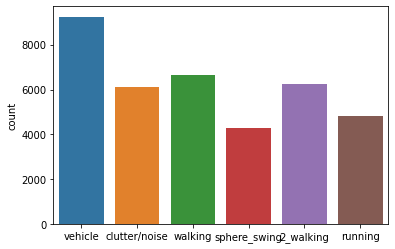

In [13]:
# Creating a count plot
sns.countplot(havs_labels)

C:\Users\nyasha\anaconda3\envs\masters\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

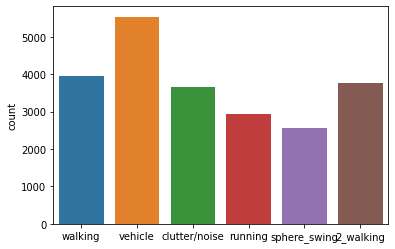

In [14]:
sns.countplot(y_train)

The dataset is not balanced and this will need to be adressed before training.

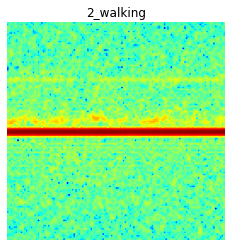

In [17]:
def plot_random_spectrogram():
    """Plots a random image from the training data"""
    image_num = np.random.randint(len(havs_data_norm))
    random_image = havs_data_norm[image_num]
    plt.imshow(random_image, cmap='jet')
    plt.title(f'{havs_labels[image_num]}')
    plt.axis('off')
    plt.show()

plot_random_spectrogram()


On plotting random images, there is evidence that some of the examples in the dataset are not clean. There are files with birds, there is a DC component, there seems to be mislabelling of some nature - the slice taken can be the end or beginning of am file.

In [18]:
walking_data = x_train[np.where(y_train == 'walking')]
vehicle_data = x_train[np.where(y_train == 'vehicle')]
clutter_data = x_train[np.where(y_train == 'clutter/noise')]
sphere_swing_data = x_train[np.where(y_train == 'sphere_swing')]
walking_2_data = x_train[np.where(y_train == '2_walking')]
running_data = x_train[np.where(y_train == 'running')]

In [19]:
avg_clutter_image = sum(clutter_data)/len(clutter_data)
avg_vehicle_image = sum(vehicle_data)/len(vehicle_data)
avg_walking_image = sum(walking_data)/len(walking_data)
avg_sphere_swing_image = sum(sphere_swing_data)/len(sphere_swing_data)
avg_running_image = sum(running_data)/len(running_data)
avg_walking_2_image = sum(walking_2_data)/len(walking_2_data)


In [20]:
avg_clutter_image.shape

(128, 128)

Figure(1600x800)


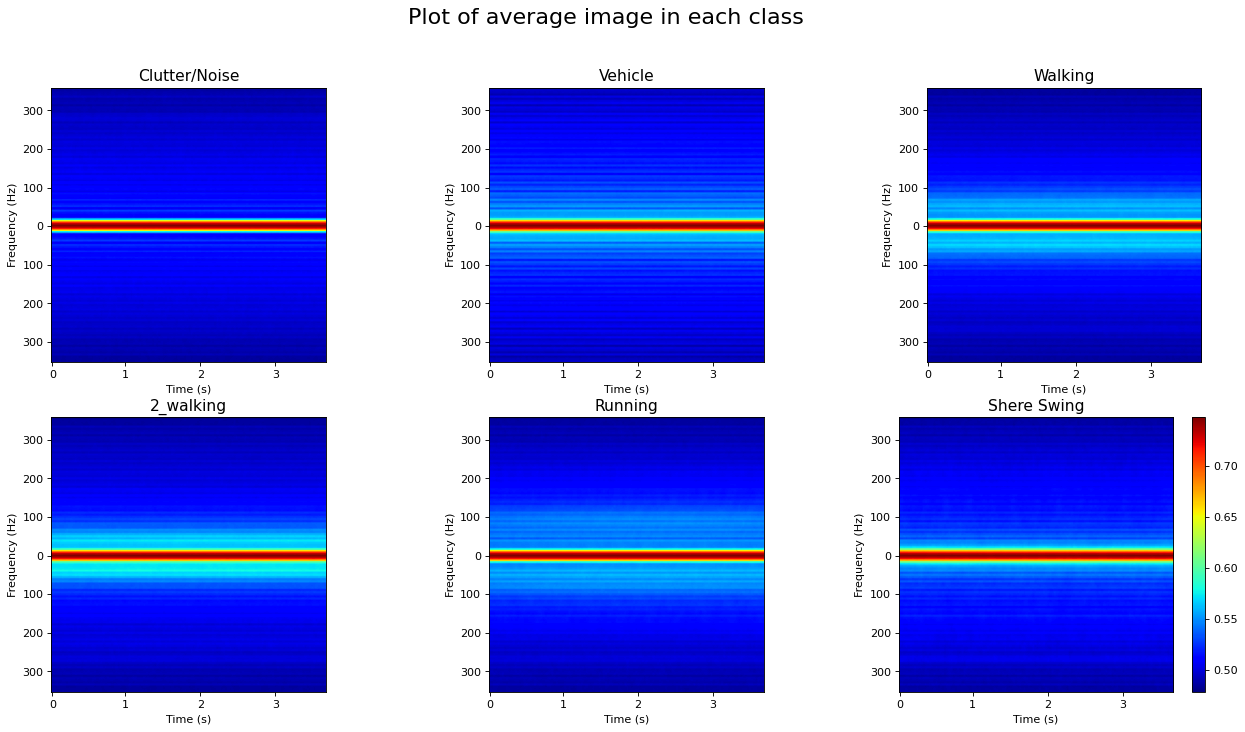

In [21]:
my_dpi = 80
fig = plt.figure(figsize=(20, 10), dpi=my_dpi)
print(fig)

fig.suptitle('Plot of average image in each class', fontsize=20)

# Add plots
ax1 = fig.add_subplot(2, 3, 1)
cs = ax1.imshow(avg_clutter_image, cmap='jet')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Frequency (Hz)')
ax1.set_yticks([10,  28, 46, 64, 82, 100, 118])
ax1.set_yticklabels([300, 200, 100, 0, 100, 200, 300])
ax1.set_xticks([0, 34, 69, 104])
ax1.set_xticklabels([0, 1, 2, 3])  

ax1.set_title('Clutter/Noise',   
             fontsize = 14) 

ax2 = fig.add_subplot(2, 3, 2)
ax2.imshow(avg_vehicle_image, cmap='jet')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Frequency (Hz)')
ax2.set_title('Vehicle',   
             fontsize = 14)
ax2.set_yticks([10,  28, 46, 64, 82, 100, 118])
ax2.set_yticklabels([300, 200, 100, 0, 100, 200, 300])
ax2.set_xticks([0, 34, 69, 104])
ax2.set_xticklabels([0, 1, 2, 3])  

ax3 = fig.add_subplot(2, 3, 3)
ax3.imshow(avg_walking_image, cmap='jet')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Frequency (Hz)')
ax3.set_title('Walking',   
             fontsize = 14)
ax3.set_yticks([10,  28, 46, 64, 82, 100, 118])
ax3.set_yticklabels([300, 200, 100, 0, 100, 200, 300]) 
ax3.set_xticks([0, 34, 69, 104])
ax3.set_xticklabels([0, 1, 2, 3])  

ax4 = fig.add_subplot(2, 3, 4)
ax4.imshow(avg_walking_2_image, cmap='jet')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Frequency (Hz)')
ax4.set_title('2_walking',   
             fontsize = 14) 
ax4.set_yticks([10,  28, 46, 64, 82, 100, 118])
ax4.set_yticklabels([300, 200, 100, 0, 100, 200, 300])
ax4.set_xticks([0, 34, 69, 104])
ax4.set_xticklabels([0, 1, 2, 3])               

ax5 = fig.add_subplot(2, 3, 5)
ax5.imshow(avg_running_image, cmap='jet')
ax5.set_xlabel('Time (s)')
ax5.set_ylabel('Frequency (Hz)')
ax5.set_title('Running',   
             fontsize = 14)
ax5.set_yticks([10,  28, 46, 64, 82, 100, 118])
ax5.set_yticklabels([300, 200, 100, 0, 100, 200, 300]) 
ax5.set_xticks([0, 34, 69, 104])
ax5.set_xticklabels([0, 1, 2, 3])              

ax6 = fig.add_subplot(2, 3, 6)
ax6.imshow(avg_sphere_swing_image, cmap='jet')
ax6.set_xlabel('Time (s)')
ax6.set_ylabel('Frequency (Hz)')
ax6.set_title('Shere Swing',   
             fontsize = 14) 
ax6.set_yticks([10,  28, 46, 64, 82, 100, 118])
ax6.set_yticklabels([300, 200, 100, 0, 100, 200, 300])
ax6.set_xticks([0, 34, 69, 104])
ax6.set_xticklabels([0, 1, 2, 3]) 

fig.colorbar(cs)
fig.savefig('Subplot_avg_images.png')

Text(0.5, 1.0, 'Walking')

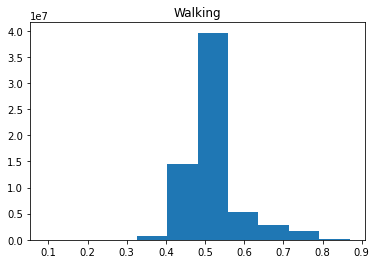

In [23]:
plt.hist(walking_data.flatten())
plt.title("Walking")

Text(0.5, 1.0, 'Running')

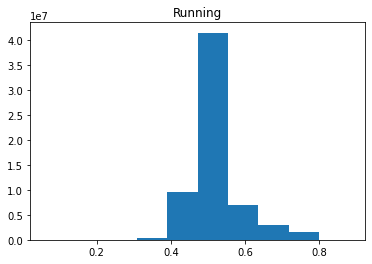

In [390]:
plt.hist(running_data.flatten()) 
plt.title("Running")

Text(0.5, 1.0, 'Vehicle')

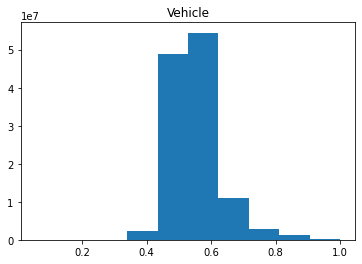

In [391]:
plt.hist(vehicle_data.flatten())
plt.title("Vehicle")

Text(0.5, 1.0, 'Clutter/noise')

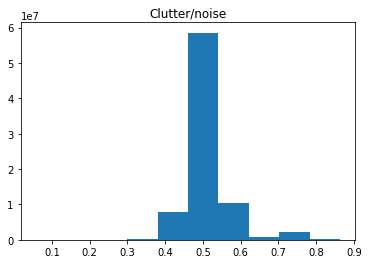

In [392]:
plt.hist(clutter_data.flatten())
plt.title("Clutter/noise")

Text(0.5, 1.0, 'Sphere Swing')

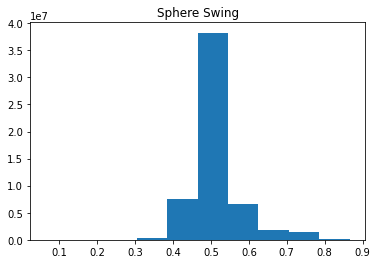

In [393]:
plt.hist(sphere_swing_data.flatten())
plt.title("Sphere Swing")

Text(0.5, 1.0, '2_Walking')

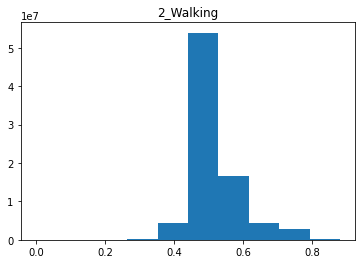

In [394]:
plt.hist(walking_2_data.flatten())
plt.title("2_Walking")

In [25]:
# save numpy array as npz file
from numpy import asarray
from numpy import savez_compressed

# save to npy file
savez_compressed('Processed Data/processed_data.npz', x_train=x_train, x_test=x_test, x_val=x_val, y_train=y_train, y_test=y_test, y_val=y_val)